In [1]:
# IMPORT REQUIRED LIBRARIES

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt             
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as Models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import cv2

In [2]:
IMAGE_SIZE = (228, 228)

BATCH_SIZE = 32

In [3]:
# LOADING THE DATASET
train_dir='C:/Users/ben/Downloads/Zeeler-new/CNN/seg_train'
test_dir='C:/Users/ben/Downloads/Zeeler-new/CNN/seg_test'

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 11000 files belonging to 5 classes.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 2305 files belonging to 5 classes.


In [8]:
class_names = train_ds.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea']


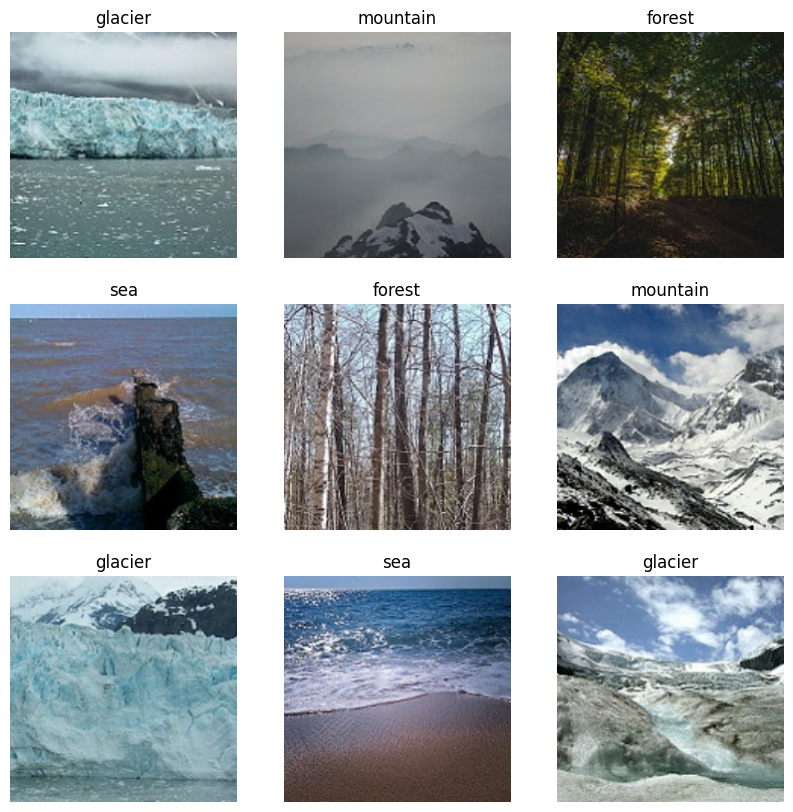

In [9]:
# GIVE A VISUALIZATION OF YOUR MODEL

# VISUALIZE THE DATA
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
num_classes = len(class_names)

In [11]:
# MODEL CREATION

model = Models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(228,228,3)))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [12]:
# MODEL SUMMARY
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 226, 226, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 113, 113, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [13]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [15]:
# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

In [16]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2,
    callbacks=callback_list
)

Epoch 1/2
344/344 [==============================] - ETA: 0s - loss: 1.1649 - accuracy: 0.6035

INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


344/344 [==============================] - 3034s 9s/step - loss: 1.1649 - accuracy: 0.6035 - val_loss: 0.9144 - val_accuracy: 0.6443
Epoch 2/2
344/344 [==============================] - ETA: 0s - loss: 0.7518 - accuracy: 0.7175 

INFO:tensorflow:Assets written to: bestvalue\assets


INFO:tensorflow:Assets written to: bestvalue\assets


344/344 [==============================] - 3755s 11s/step - loss: 0.7518 - accuracy: 0.7175 - val_loss: 0.6122 - val_accuracy: 0.7844


In [21]:
# MODEL SUMMARY
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 226, 226, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 113, 113, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='test set')
plt.legend()

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

In [ ]:
# Prediction on unseen image data
# load the prediction data and predict class on unseen data
def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

pred_dir = 'C:/Users/ben/Downloads/Zeeler-new/CNN/seg_pred'

images_paths = getImagePaths(pred_dir)
len(images_paths)

In [ ]:
# images path list to numpy array using cv2.imread module
file_array = []

for file in images_paths[:9]:
    img_ = image.load_img(file, target_size=(228, 228))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255. 
    file_array.append(img_processed)
    
file_array = np.array(file_array)

In [ ]:
classes = train_ds.class_names
print(classes)

In [ ]:
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(228, 228))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.
    
    prediction = model.predict(img_processed)
    
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(str(classes[index]).title()), size=18, color='red')
    plt.imshow(img_array)

In [ ]:
predict_image('C:/Users/ben/Downloads/Zeeler-new/CNN/seg_pred/10045.jpg', model)

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

# Combine train and validation datasets for cross-validation
full_train_ds = train_ds.concatenate(val_ds)

# Convert dataset to numpy arrays
images = []
labels = []

for image_batch, label_batch in full_train_ds:
    images.extend(image_batch.numpy())
    labels.extend(label_batch.numpy())

images = np.array(images)
labels = np.array(labels)

# Initialize KFold cross-validator
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

# Lists to store results
accuracies = []
confusion_matrices = []

# Perform 10-fold cross-validation
for train_index, test_index in kfold.split(images, labels):
    train_images, test_images = images[train_index], images[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]
    
    # Clear the model before re-compiling
    tf.keras.backend.clear_session()
    
    # Create and compile the model (Use the same model architecture you defined earlier)
    model = Models.Sequential()
    # ... Add layers as defined earlier ...
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    
    # Fit the model on the training data
    history = model.fit(
        train_images,
        train_labels,
        validation_data=(test_images, test_labels),
        epochs=35,
        batch_size=BATCH_SIZE,
        callbacks=callback_list,
        verbose=0
    )
    
    # Evaluate the model on the test data
    _, accuracy = model.evaluate(test_images, test_labels, verbose=0)
    accuracies.append(accuracy)
    
    # Make predictions and create the confusion matrix
    y_pred = model.predict(test_images)
    y_pred_labels = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(test_labels, y_pred_labels)
    confusion_matrices.append(cm)

# Calculate the mean and standard deviation of accuracies
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

# Calculate the average confusion matrix
avg_confusion_matrix = np.mean(confusion_matrices, axis=0)

# Display the results
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
print("Average Confusion Matrix:")
print(avg_confusion_matrix)
